<a href="https://colab.research.google.com/github/ZeeMurphy/Projects-Z/blob/main/Project2_Data201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset used in this project is a subset of the National Health and Nutrition Examination Survey (NHANES), which was created to assess the health and nutritional status of adults and children in the United States. It was funded by the Centers for Disease Control and Prevention (CDC) through its National Center for Health Statistics (NCHS). The instances in this dataset represent survey respondents from across the United States, with data collected through interviews, physical examinations, and laboratory tests. Some preprocessing was performed, including categorizing respondents 65 years and older as "Senior" and those under 65 as "Adult." The dataset includes 2,279 rows and 10 columns, with variables such as SEQN, age group, Age, Gender, Vigorous Activity, BMI, Fasting Glucose, Diabetes, Two Hour Glucose, and Blood Insulin Level.   
For the logistic regression evaluation, this project aims to explore whether health and activity factors can predict a respondent’s diabetes status. Key questions include: How well do variables like BMI, fasting glucose, and vigorous physical activity predict whether a respondent is diabetic, non-diabetic, or borderline? Can a multinomial logistic regression model accurately classify individuals into the three diabetes categories? Additionally, comparisons between the one-vs-all and one-vs-one strategies will be used to assess model performance and interpretability.   
Since we have three possible outcomes for the target variable (diabetic, non-diabetic, and borderline), we would use multinomial logistic regression, not binary logistic regression.


In [98]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
from sklearn.multiclass import OneVsOneClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [99]:
df=pd.read_csv('https://raw.githubusercontent.com/ZeeMurphy/Projects-Z/refs/heads/main/NHANES_age_prediction.csv')

In [100]:
df.head()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [101]:
unique_values = df['DIQ010'].unique()

print(unique_values)

[2. 1. 3.]


 diabetes classification (based on 123 variables). From this link I think 1,2,3 in column DIQ010 stands for 1=	Yes (Diabetic), 2= No 3= 	Borderline (https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DIQ.htm)

In [102]:
unique_values = df['PAQ605'].unique()

print(unique_values)

[2. 1. 7.]


from this code book: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/PAQ_J.htm values 1,2 7 in column PAQ0605 stands for:
Does {your/SP's} work involve vigorous-intensity activity that causes large increases in breathing or heart rate like carrying or lifting heavy loads, digging or construction work for at least 10 minutes continuously?
1	Yes
2	No
7	Refused

In [103]:
df.shape

(2278, 10)

In [104]:
df.isnull().sum()

,0
SEQN,0
age_group,0
RIDAGEYR,0
RIAGENDR,0
PAQ605,0
BMXBMI,0
LBXGLU,0
DIQ010,0
LBXGLT,0
LBXIN,0


In [105]:
df.rename(columns={
    'RIDAGEYR':'Age',
    'RIAGENDR':'Gender',
    'PAQ605': 'Vigorous_activity',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Fasting_Glucose',
    'DIQ010': 'Diabetes',
    'LBXGLT': 'Two_Hour_Glucose',
     'LBXIN': 'Blood_Insuline_Level'

}, inplace=True)

In [106]:
df.head(5)

,SEQN,age_group,Age,Gender,Vigorous_activity,BMI,Fasting_Glucose,Diabetes,Two_Hour_Glucose,Blood_Insuline_Level
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [107]:
unique_values = df['Diabetes'].unique()

print(unique_values)

[2. 1. 3.]


According the [Code book](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DIQ_J.htm#:~:text=SEQN%20%2D%20Respondent%20sequence%20number,DIQ175E%20%2D%20Race) , 1=Yes, 2=No, 3=Borderline

In [108]:
df['Diabetes'].value_counts()

,count
Diabetes,
2.0,2199
3.0,58
1.0,21


The hours a respondent performs vigorous activity per week:

In [109]:
Unique_values = df['Vigorous_activity'].unique()

print(Unique_values)

[2. 1. 7.]


In [110]:
df.describe()

,SEQN,Age,Gender,Vigorous_activity,BMI,Fasting_Glucose,Diabetes,Two_Hour_Glucose,Blood_Insuline_Level
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


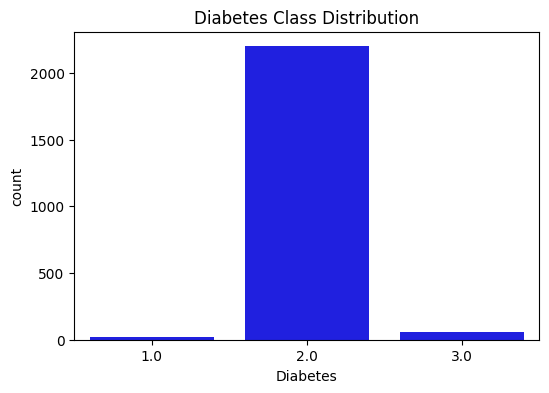

In [111]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Diabetes', data=df, color='blue')
plt.title('Diabetes Class Distribution')
plt.show()

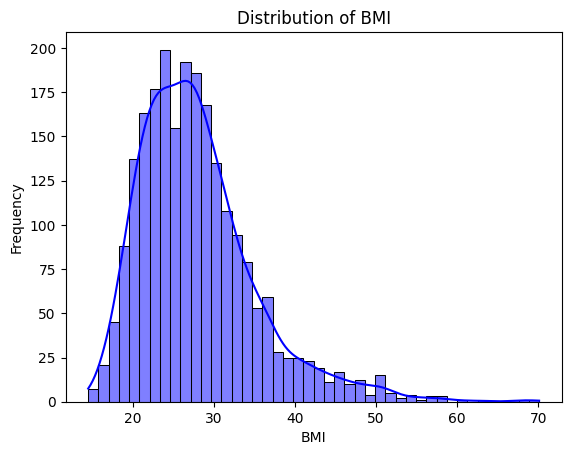

In [112]:
sns.histplot(data=df, x='BMI', kde=True, color='blue')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

According to the CDC, obesity is defined as a Body Mass Index (BMI) of 30.0 or higher. Severe obesity is defined as a BMI of 40.0 or higher.

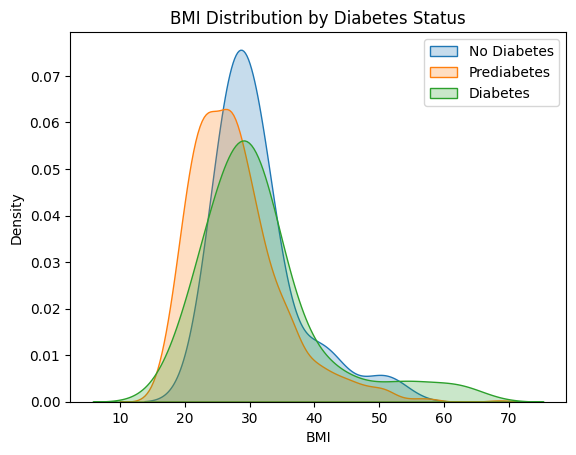

In [113]:
sns.kdeplot(data=df[df['Diabetes'] == 1]['BMI'], label='No Diabetes', fill=True)
sns.kdeplot(data=df[df['Diabetes'] == 2]['BMI'], label='Prediabetes', fill=True)
sns.kdeplot(data=df[df['Diabetes'] == 3]['BMI'], label='Diabetes', fill=True)
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.legend()
plt.show()


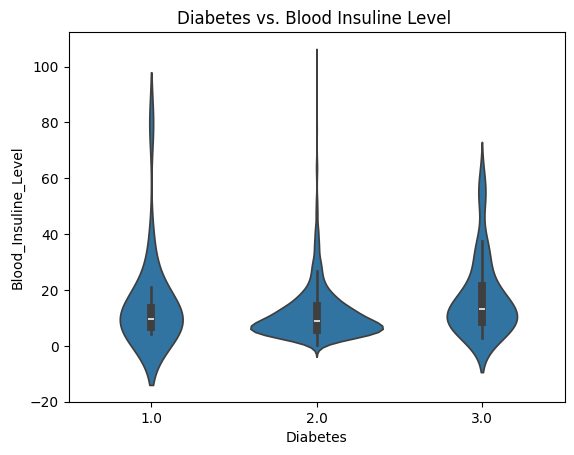

In [114]:
sns.violinplot(data=df, x='Diabetes', y='Blood_Insuline_Level')
plt.title('Diabetes vs. Blood Insuline Level ')
plt.show()

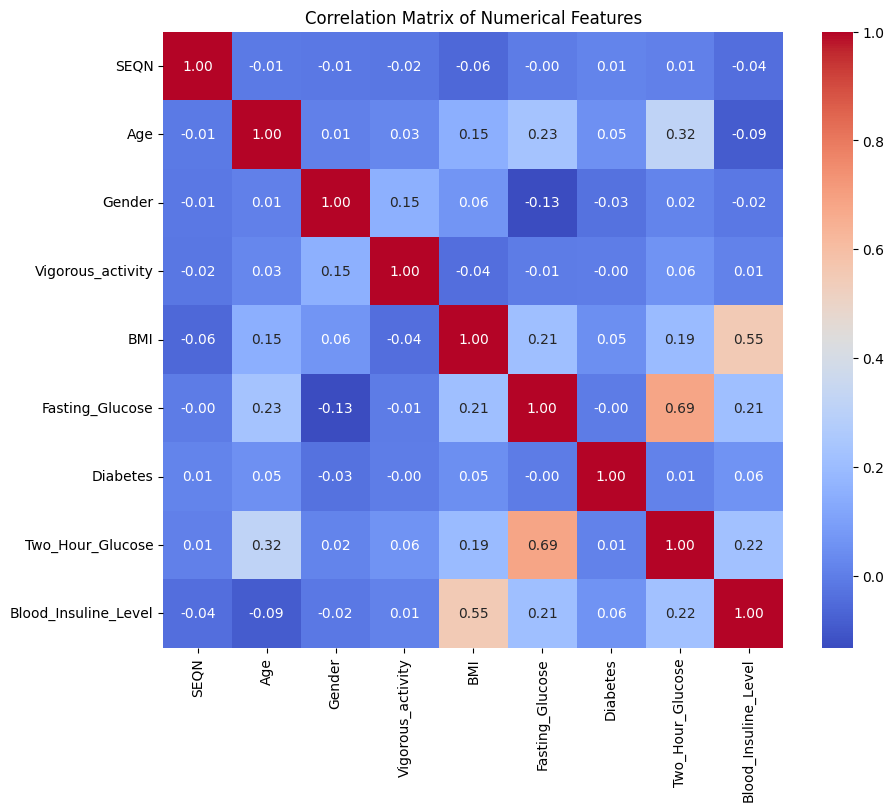

In [115]:
# numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
corr_matrix = numerical_features.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

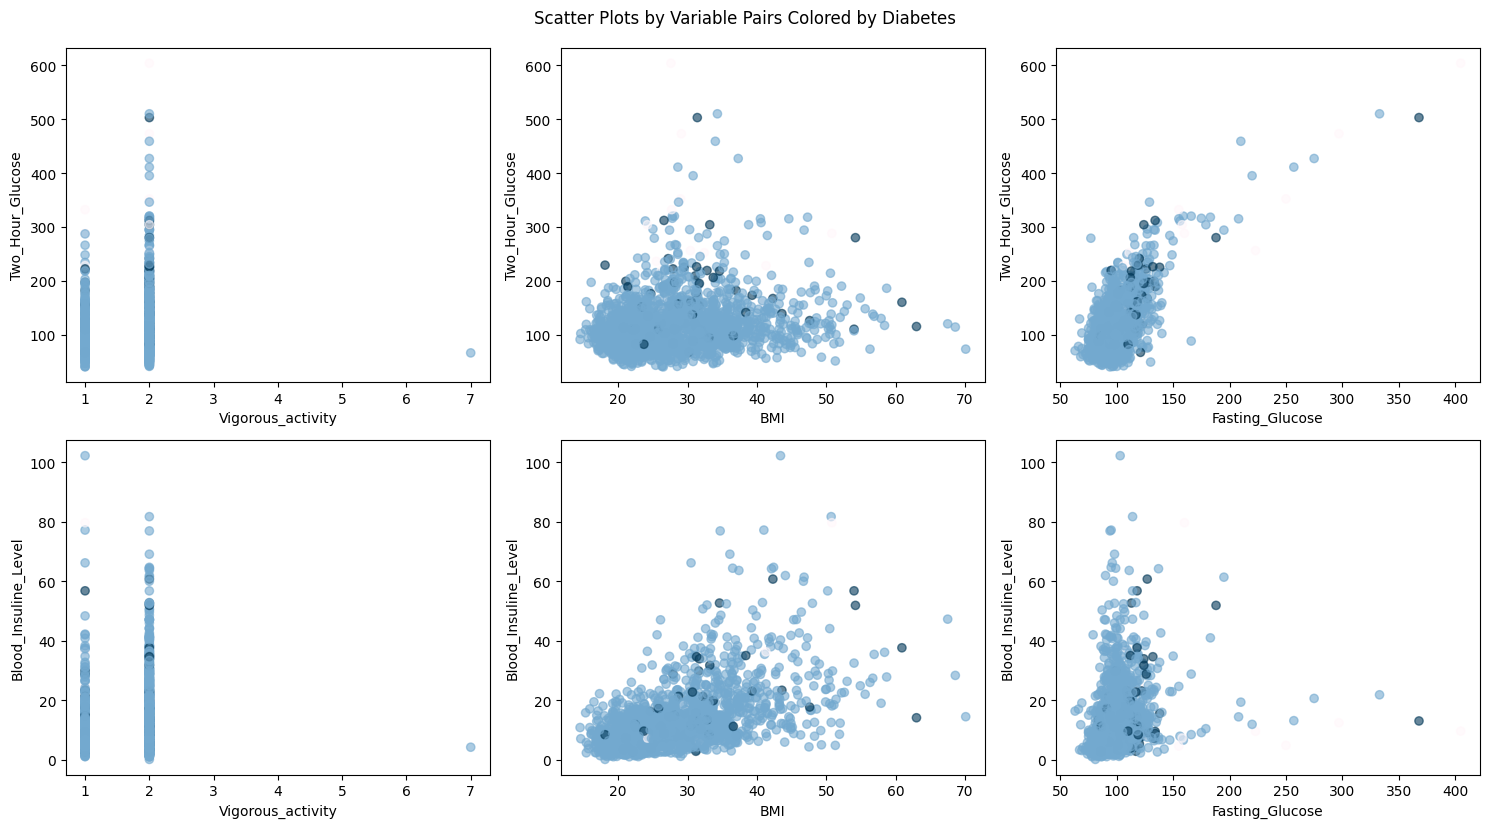

In [116]:
x_vars = ['Vigorous_activity', 'BMI', 'Fasting_Glucose']
y_vars = ['Two_Hour_Glucose', 'Blood_Insuline_Level']

fig, axes = plt.subplots(len(y_vars), len(x_vars), figsize=(15, 8))

for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        axes[i, j].scatter(df[x], df[y], alpha=0.6, c=df['Diabetes'], cmap='PuBu')
        axes[i, j].set_xlabel(x)
        axes[i, j].set_ylabel(y)

plt.tight_layout()
plt.suptitle("Scatter Plots by Variable Pairs Colored by Diabetes", y=1.03)
plt.show()


Features and Target:
Target Variable (y): This is the Diabetes column, which has three unique values (1 = Non-diabetic, 2 = Diabetic, 3 = Borderline).

Features (X): These are the independent variables we want to use to predict the target. Based on our question, the features we would use are:

BMI (continuous)

Fasting Glucose (continuous)

Vigorous physical activity (continuous)

In [117]:
# Logistic Regression to train, test and predict Diabetes:

X = df.drop(columns=['Diabetes', 'age_group', 'SEQN'])   # Features: everything except Diabetes and age_group
y = df['Diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
scaler = preprocessing.StandardScaler()   # Standardize the feature values
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000)  #multinomial logistic regression model
LogReg.fit(X_train, y_train)  # Train the model
y_pred = LogReg.predict(X_test) #Predict

#results
print('Classes:', LogReg.classes_)
print('Intercept:', LogReg.intercept_)
print('Coefficients:', LogReg.coef_)
print('Accuracy:', LogReg.score(X_test, y_test))
print(classification_report(y_test, y_pred))


Classes: [1. 2. 3.]
Intercept: [-2.95185039  3.61507244 -0.66322205]
Coefficients: [[ 0.49903993  0.53903778 -0.48683852 -0.02678592  0.05602067  0.3636293
   0.0855448 ]
 [-0.64342413 -0.20677536  0.36452447 -0.15721088 -0.15505631 -0.25653084
  -0.13635706]
 [ 0.14438419 -0.33226242  0.12231405  0.1839968   0.09903564 -0.10709845
   0.05081227]]
Accuracy: 0.9596491228070175
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         6
         2.0       0.96      1.00      0.98       548
         3.0       0.00      0.00      0.00        16

    accuracy                           0.96       570
   macro avg       0.32      0.33      0.33       570
weighted avg       0.92      0.96      0.94       570



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This code uses Multinomial Logistic Regression, which is One-vs-All by default in Scikit-learn when we're using the 'multinomial' option with LogisticRegression(). This means that the model treats each class as a separate binary classification problem and predicts the class with the highest probability. Predicting classes: y_pred = LogReg.predict(X_test) does this. Predicting class probabilities: y_pred_proba = LogReg.predict_proba(X_test) does this.
Intepreting the results:
Accuracy: almost 96%, which at first glance would mean the model predicted the diabetes class 96% of the time on the test data. As we can see, the precision, Recall, f1-score are 0 for class 1 and 3. It means the model doesn't predict these classes at all. This means either our data is imbalanced or the model is biased toward predicting only the majority class. We do know that our data is imbalanced so we use class_weight='balanced' in your model to fix this issue.This tells the model to give more importance to underrepresented classes.


In [118]:
# Logistic Regression to train, test and predict Diabetes:

X = df.drop(columns=['Diabetes', 'age_group', 'SEQN'])   # Features: everything except Diabetes and age_group
y = df['Diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
scaler = preprocessing.StandardScaler()   # Standardize the feature values
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')  #multinomial logistic regression model
LogReg.fit(X_train, y_train)  # Train the model
y_pred = LogReg.predict(X_test) #Predict

#results
print('Classes:', LogReg.classes_)
print('Intercept:', LogReg.intercept_)
print('Coefficients:', LogReg.coef_)
print('Accuracy:', LogReg.score(X_test, y_test))
print(classification_report(y_test, y_pred))


Classes: [1. 2. 3.]
Intercept: [-1.39673924  1.08716984  0.30956939]
Coefficients: [[ 0.55088397  0.8956776  -0.45513647  0.0679994   0.11730956  0.59364742
  -0.06064261]
 [-0.70987186 -0.50950537  0.30352509 -0.22621173 -0.32732052 -0.44503983
  -0.01232618]
 [ 0.15898789 -0.38617222  0.15161138  0.15821233  0.21001095 -0.14860759
   0.07296879]]
Accuracy: 0.7140350877192982
              precision    recall  f1-score   support

         1.0       0.04      0.50      0.07         6
         2.0       0.98      0.73      0.84       548
         3.0       0.07      0.38      0.11        16

    accuracy                           0.71       570
   macro avg       0.36      0.53      0.34       570
weighted avg       0.95      0.71      0.81       570



Class 1(Diabetes): Intercept = -1.40
Class 2 (Non-Diabetes): Intercept = 1.09
Class 3 (Pre-Diabetes): Intercept = 0.31
A higher intercept means the model is more likely to predict that class.

Coefficients: Each row in the matrix corresponds to a class, and each column to a feature
Classification report: Class 2 dominated the dataset. Class 1 and 3 are underrepresented.
Class 1 precision = 0.04 → when it predicts class 1, it's almost always wrong. Class 1 recall = 0.50 → it caught 3 out of 6 class 1 cases.

Same trend for Class 3: very low precision and recall.
Model Accuacy: 71% (This is the proportion of total correct predictions on the test set. )
Overall the model performs well on the majority class (2.0), but poorly on the minority classes (1.0 and 3.0).


Next, we are looking at probability distribution over all classes for 5 samples to understand how confident the model is in that prediction.But because our dataset is imbalanced we need further steps that follow.

In [119]:
# Predict the class probabilities of the test data
y_pred_proba = LogReg.predict_proba(X_test)

# Print the predicted probabilities for the first 5 samples
print("Predicted probabilities for the first 5 samples:")
print(y_pred_proba[:5])

Predicted probabilities for the first 5 samples:
[[0.00527208 0.7242102  0.27051773]
 [0.04776862 0.78934358 0.1628878 ]
 [0.03110531 0.34184457 0.62705012]
 [0.13302084 0.10114444 0.76583472]
 [0.02538401 0.50192581 0.47269018]]


We are looking at probability distribution over all classes for 5 samples to understand how confident the model is in that prediction.But because our dataset is imbalanced we need further steps that follow.

**One-vs-All (OvA):**

Strategy: This approach trains one classifier for each class. Each classifier predicts whether an instance belongs to that class or not. For a three-class classification, there will be three classifiers, each one predicting if the sample belongs to class 1, 2, or 3.

Probability: The probabilities output by OvA classifiers represent the likelihood that a sample belongs to a particular class. In the case of our probabilities, each row in the predicted probabilities corresponds to the predicted probabilities for each class (1, 2, and 3). These are calculated by considering all classifiers together.
This means that for the first sample:

The classifier for class 1 predicts a probability of 0.0053 for the sample belonging to class 1.

The classifier for class 2 predicts a probability of 0.72 for the sample belonging to class 2 (very high probability).

The classifier for class 3 predicts a probability of 0.27 for the sample belonging to class 3.

**Now for One-vs-One:**
We keep existing multinomial logistic regression code (One-vs-All) for the first part. This will handle the multi-class classification problem.and we add the One-vs-One classifier:

We use OneVsOneClassifier from sklearn.multiclass to wrap around a LogisticRegression model and handle the One-vs-One approach.

The OneVsOneClassifier trains a separate binary classifier for each pair of classes, which makes it more computationally expensive but can perform well when classes are very different from each other.



In [120]:
# 2. Implement One-vs-One classification with Logistic Regression
ovo_classifier = OneVsOneClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Train and predict with OvO
ovo_classifier.fit(X_train, y_train)
y_pred_ovo = ovo_classifier.predict(X_test)

# Print results for One-vs-One
print("\nOne-vs-One (OvO) Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_ovo))
print(classification_report(y_test, y_pred_ovo))

y_pred_proba_ovo = []
for clf in ovo_classifier.estimators_:
    y_pred_proba_ovo.append(clf.predict_proba(X_test))

# the first 5 rows of predicted probabilities (for each binary classifier)
print("Predicted probabilities for the first 5 samples (One-vs-One):")
print([probs[:5] for probs in y_pred_proba_ovo])  # Displaying the probabilities for the first 5 samples



One-vs-One (OvO) Logistic Regression:
Accuracy: 0.7263157894736842
              precision    recall  f1-score   support

         1.0       0.04      0.50      0.08         6
         2.0       0.99      0.74      0.84       548
         3.0       0.08      0.44      0.13        16

    accuracy                           0.73       570
   macro avg       0.37      0.56      0.35       570
weighted avg       0.95      0.73      0.82       570

Predicted probabilities for the first 5 samples (One-vs-One):
[array([[0.0072342 , 0.9927658 ],
       [0.06108212, 0.93891788],
       [0.06466127, 0.93533873],
       [0.50078075, 0.49921925],
       [0.0445449 , 0.9554551 ]]), array([[0.02722314, 0.97277686],
       [0.22480968, 0.77519032],
       [0.06541834, 0.93458166],
       [0.19175409, 0.80824591],
       [0.06794535, 0.93205465]]), array([[0.69111272, 0.30888728],
       [0.82671269, 0.17328731],
       [0.26364121, 0.73635879],
       [0.11125806, 0.88874194],
       [0.51358473, 0.

Explanation: The code now prints the probabilities for the first 5 samples for each binary classifier in the One-vs-One model.

One-vs-One (OvO):

Strategy: This approach trains one classifier for every pair of classes. For a three-class classification problem, OvO will train three classifiers: one for class 1 vs. class 2, one for class 1 vs. class 3, and one for class 2 vs. class 3.

Probability: In this case, each classifier only provides a binary output (probability for class 1 vs class 2, for example). However, the final classification decision must be made by combining the results from all classifiers. Each pair of classes outputs two probabilities, so OvO provides a list of predicted probabilities for each pair of classes.   
Class 1 (only 6 samples):
Precision: 0.04 – Out of all the times the model predicted class 1, only 4% were actually class 1.

Recall: 0.50 – The model correctly identified 50% (3 out of 6) of the actual class 1 instances.

F1-score: 0.08 – A low score, but not zero anymore. That’s a big improvement from before, when class 1 had no predictions at all.

Class 2 (majority class, 548 samples):
Precision: 0.99 – Nearly all predictions of class 2 were correct.

Recall: 0.74 – About 74% of the actual class 2 samples were correctly predicted.

F1-score: 0.84 – Very good; still the strongest class, as expected.

Class 3 (16 samples):
Precision: 0.08 – Low precision, but at least the model is now predicting class 3.

Recall: 0.44 – The model caught 44% (around 7 out of 16) of the actual class 3 cases.

F1-score: 0.13 – Still low, but significantly better than zero.

Macro Average (equal weight to each class):
Precision: 0.37

Recall: 0.56

F1-score: 0.35

Weighted Average (accounts for class size):
Precision: 0.95

Recall: 0.73

F1-score: 0.82

Key Observations:
Accuracy is slightly higher in OvO (72.6% vs 71.0%).

OvO performs slightly better on minority classes (1 and 3) in terms of recall and F1-score.

Both models heavily favor class 2, but OvO handles class imbalance marginally better.

In [121]:
diabetes_percentages = df['Diabetes'].value_counts(normalize=True) * 100
print(diabetes_percentages)

Diabetes
2.0    96.532046
3.0     2.546093
1.0     0.921861
Name: proportion, dtype: float64


As we can see, class 2 in our dataset includes approximately 96.53% of the istances. This is why the accuracy is not correct.

|Predicted Class | 1   | 2   | 3   |
|:---------------------------------|:---:|:---:|:---:|
|(**Actual class**) **1**         | TP  | FN  | FN  |
|(**Actual class**) **2**           | FP  | TN  | FN  |
|(**Actual class**) **3**          | FP  | FN  | TN  |

In [122]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[  3,   2,   1],
       [ 68, 398,  82],
       [  5,   5,   6]])

Class 1 (True label = 1.0):
3 samples were correctly predicted as class 1 (True Positives).
2 were incorrectly predicted as class 2.
1 was incorrectly predicted as class 3.
So, 3 out of 6 class 1 instances were classified correctly. Recall = 3/6 = 0.50.

Class 2 (True label = 2.0):
398 samples were correctly predicted as class 2.
68 were incorrectly predicted as class 1.
82 were incorrectly predicted as class 3.
Recall for class 2 = 398 / 548 ≈ 0.73.
Class 2 has the highest support, so performance here heavily impacts overall accuracy.

Class 3 (True label = 3.0):
6 were correctly predicted.
5 were misclassified as class 1.
5 were misclassified as class 2.
Recall for class 3 = 6/16 = 0.375.

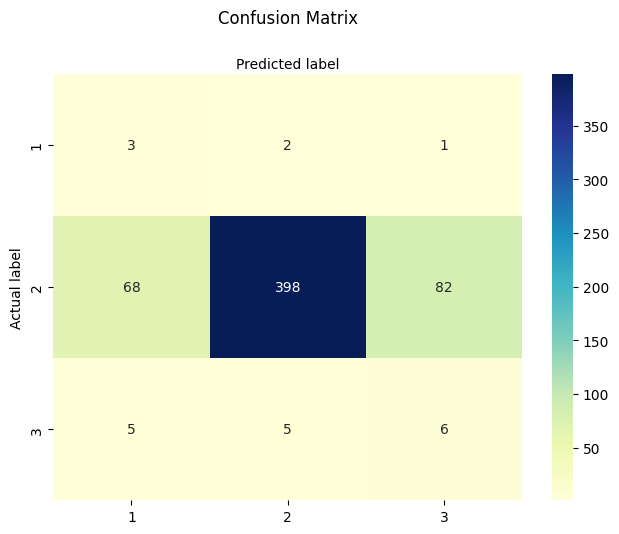

In [123]:
categories = [1, 2, 3]  # Adjust categories for three classes

fig, ax = plt.subplots()
plt.xticks([0, 1, 2], categories)
plt.yticks([0, 1, 2], categories)

# Create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu", fmt='g', xticklabels=categories, yticklabels=categories)

ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()


In [124]:
# Dummy classifier in SKlearn
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=1))
print("F1-score:", f1_score(y_test, y_pred, average='weighted', zero_division=1))

Accuracy: 0.7140350877192982
Precision: 0.9470945418462892
Recall: 0.7140350877192981
F1-score: 0.8069973285015575


The Dummy classifier predicts the most frequent class for the training data.

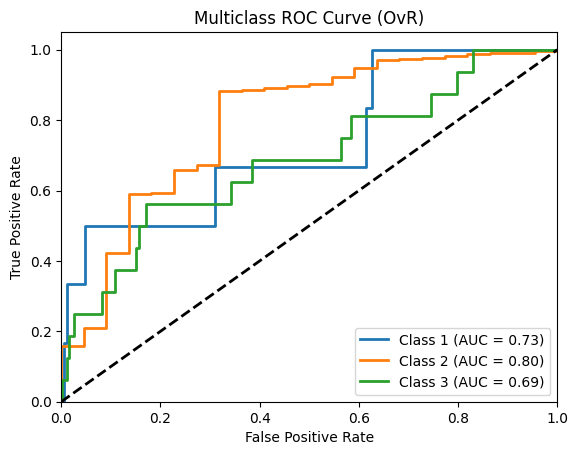

In [125]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Binarize y_test for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[1.0, 2.0, 3.0])  # shape: (n_samples, 3)

# Get predicted probabilities for each class
y_score = LogReg.predict_proba(X_test)  # shape: (n_samples, 3)

# Plot ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class %d (AUC = %0.2f)' % (i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (OvR)')
plt.legend(loc='lower right')
plt.show()


AUC stands for Area Under the ROC Curve and it tells us how well our model can distinguish between classes.
AUC ≈ 0.80 for Class 2: Your model is good at distinguishing Class 2 from others.

AUC ≈ 0.73 and 0.69 for Classes 1 and 3: Decent but weaker performance; likely due to the class imbalance (very few samples of 1 and 3).

AUC > 0.5 shows the model is learning useful signal for all classes, even if it’s still struggling on the minority classes.
